<b>Dans ce notebook on nettoie le dataset sur la base des éléments décrits par le notebook Discover</b>

# Table of contents
1. [Load du dataset](#load)
2. [Mise à l'écart des features redondantes](#purge_redund)
3. [Mise à l'écart des features 100% NaN](#purge_nan)
4. [Mise à l'écart des features de détail nutritionnel](#detail_features)
5. [Création feature PNNS_3](#create_pnns3)
6. [Traitement des outliers](#outliers) 
7. [Imputations](#imputations)

    7.1 [High density features](#impute_high_density)
    
    7.2 [Mid density features](#impute_mid_density)
   


<b  style="background-color:tomato;font-size:14px;">1. LOAD DU DATASET<b>
    <a id="load"></a>   

In [149]:
import numpy as np 
import pandas as pd
import seaborn as sns
import math

import matplotlib.pyplot as plt
%matplotlib inline
import re

try:
    del data
except:
    dummy=1

#On ne prend qu'un échantillon du fait des limitations mémoire de la machine
data=pd.read_csv('../dataset/en.openfoodfacts.org.products.csv',sep='\t',low_memory=False)


<b  style="background-color:tomato;font-size:14px;">2. MISE A L'ECART DES FEATURES REDONDANTES<b>
    <a id="purge_redund"></a>  

In [151]:
columns_to_remove = []
for s in data.columns:
    if "_tags" in s: 
        t = s.replace('_tags', '')
        u = s.replace('_tags', '_en')
        print("{:<20} 'no suffix' -> {} ; '_en' suffix -> {}".format(s,t in data.columns, u in data.columns))
        if t in data.columns: columns_to_remove.append(t)
        if u in data.columns: columns_to_remove.append(u)
print('data shape before removal: ' + str(data.shape))
data.drop(columns_to_remove, axis = 1, inplace = True)
print('data shape after removal: ' + str(data.shape))

packaging_tags       'no suffix' -> True ; '_en' suffix -> False
brands_tags          'no suffix' -> True ; '_en' suffix -> False
categories_tags      'no suffix' -> True ; '_en' suffix -> True
origins_tags         'no suffix' -> True ; '_en' suffix -> True
manufacturing_places_tags 'no suffix' -> True ; '_en' suffix -> False
labels_tags          'no suffix' -> True ; '_en' suffix -> True
emb_codes_tags       'no suffix' -> True ; '_en' suffix -> False
cities_tags          'no suffix' -> True ; '_en' suffix -> False
countries_tags       'no suffix' -> True ; '_en' suffix -> True
traces_tags          'no suffix' -> True ; '_en' suffix -> True
additives_tags       'no suffix' -> True ; '_en' suffix -> True
ingredients_from_palm_oil_tags 'no suffix' -> True ; '_en' suffix -> False
ingredients_that_may_be_from_palm_oil_tags 'no suffix' -> True ; '_en' suffix -> False
states_tags          'no suffix' -> True ; '_en' suffix -> True
data shape before removal: (247796, 183)
data shape after re

<b  style="background-color:tomato;font-size:14px;">3. MISE A L'ECART DES FEATURES 100% NaN<b>
    <a id="purge_nan"></a>  

In [152]:
percent_of_nans = data.isnull().sum().sort_values(ascending=False) / data.shape[0] * 100

In [153]:
useless_features = percent_of_nans[percent_of_nans == 100].index
print(useless_features)
print('data shape before removal: ' + str(data.shape))
#data.drop(useless_features, axis=1, inplace=True)
print('data shape after removal: ' + str(data.shape))

Index(['-stearic-acid_100g', '-myristic-acid_100g', '-erucic-acid_100g',
       '-mead-acid_100g', '-gondoic-acid_100g', '-elaidic-acid_100g',
       '-dihomo-gamma-linolenic-acid_100g', '-melissic-acid_100g',
       '-cerotic-acid_100g', '-lignoceric-acid_100g', 'nucleotides_100g',
       '-palmitic-acid_100g', '-lauric-acid_100g', '-capric-acid_100g',
       '-caprylic-acid_100g', 'nutrition-score-uk_100g', '-caproic-acid_100g',
       'water-hardness_100g', '-butyric-acid_100g', 'no_nutriments',
       'allergens_en', '-nervonic-acid_100g'],
      dtype='object')
data shape before removal: (247796, 162)
data shape after removal: (247796, 162)


<b  style="background-color:tomato;font-size:14px;">4. MISE A L'ECART DES FEATURES DE DETAIL NUTRITIONNEL<b>
    <a id="detail_features"></a>  

In [ ]:
columns_to_remove = []
columns_to_remove = [c for c in data.columns if (re.match('^-',c.lower()))]

print('data shape before removal: ' + str(data.shape))
data.drop(columns_to_remove, axis = 1, inplace = True)
print('data shape after removal: ' + str(data.shape))

<b  style="background-color:tomato;font-size:14px;">5. CREATION FEATURE PNNS_3<b>
    <a id="create_pnns3"></a> 

In [154]:
import math
def new_pnns(row):
    aggregates = {"Fruit juices":"Fruit juices","Fruit nectars":"Fruit juices",
                    "Legumes":"Vegetables","vegetables":"Vegetables",
                    "Vegetables":"Vegetables",
                    "fruits":"Fruits","Fruits":"Fruits",
                    "Artificially sweetened beverages":"Sweetened beverages","Sweetened beverages":"Sweetened beverages",
                    "Pizza pies and quiche":"Pizza pies and quiches","Pizza pies and quiches":"Pizza pies and quiches",
                    "cereals":"Cereals","Cereals":"Cereals"}
    
    val_group_2 = row['pnns_groups_2']
    val_group_1 = row['pnns_groups_1']
    new_val=val_group_2
    for i in aggregates: 
        if isinstance(val_group_2, str):
            if val_group_2 in i:
                return aggregates[i]    
        else:
            if math.isnan(val_group_2):
                return 'unknown'        

    return new_val    


In [155]:
data['pnns_groups_3'] = data.apply (lambda row: new_pnns(row), axis=1)

<b  style="background-color:tomato;font-size:14px;">6. TRAITEMENT DES OUTLIERS<b>
    <a id="outliers"></a>  

<p>Dans le notebook Discover nous avons mis en évidence la présence d'outliers par détection de leur valeur aberrante par rapport à la médiane (facteur 10 fois l'écart-type).</p>
<p>Dans le cadre du notebook de clean on pourrait s'attaquer à nettoyer ces outliers, notamment en leur attribuant la valeur médiane pour rétablir une cohérence de leur expression dans le dataset. </p>
<p>Ici nous faisons le choix de les laisser, car nous pensons que le traitement des outliers est avant tout un point d'attention dont il faut tenir compte, son traitement devant donner lieu à un échange avec l'équipe projet pour valider la statégie et la méthode à adopter : suppression de l'enregistrement complet, ajustement de la valeur par une méthode d'imputation (knn, médiane, moyenne) ?</p>

<b  style="background-color:tomato;font-size:14px;">7. IMPUTATIONS<b>
    <a id="imputations"></a>  

<p>On procède à l'imputation des features en NaN afin de ramener une cohérence numérique aux données à analyser.</p>
<p>Quelle que soit la méthode utilisée, cela ramène du biais dans le dataset puisqu'une information imputée n'est pas l'information exacte qui aurait pu être présente au départ. L'imputation s'appuyant sur une méthode d'approximation on peut déformer la relation d'une feature par rapport aux autres (corrélations), voir lui donner un poids qui n'aurait pas été le sien avec les vraies valeurs d'origine.</p>
<p>Ces aspects sont à discuter avec l'équipe projet.</p> 
<p>On choisit ici d'utiliser une imputation par kNN pour les features à très faible densité de NaN car on pense que cette méthode a le moins de risque de biaiser fortement ces features.</p>
<p>Pour les features à densité moyenne de NaN on retient l'imputation par la médiane car on a vu qu'il y avait des outliers identifiés par un écart de 10 fois l'écart-type, ce qui a un impact biaisant sur la moyenne. </p>

<b  style="background-color:tomato;font-size:12px;">&nbsp;&nbsp;&nbsp;&nbsp;7.1. High Density Features<b>
    <a id="impute_high_density"></a>  

In [162]:
from sklearn.impute import KNNImputer
pd.options.mode.chained_assignment = None
import math

"""
knn imputation function 
"""
def knn_imputation(df_knn,nn):
    
    imputer = KNNImputer(n_neighbors=nn, weights='uniform', metric='nan_euclidean')

    df_filled = imputer.fit_transform(df_knn)

    return df_filled[:,1]

"""
median imputation function 
"""
def median_imputation(df,feature):
    df_feature_median = df[feature].median()

    df.loc[(df[feature].isnull()),feature]=df_feature_median

    return df[feature]

"""
add value labels to bar plot function 
"""
def add_value_labels(ax, spacing=5):

    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        space = spacing
        
        va = 'bottom'

        if y_value < 0:
            space *= -1
            va = 'top'

        label = "{:.1f}".format(y_value)

        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points", 
            ha='center',                
            va=va)                      

"""
imputation algorithm 
"""
def imputation(data,features,type):
    mean_updates=pd.DataFrame()
    mean_dict={"feature":[],"original_mean":[],"original_std":[],"new_mean":[],"new_std":[]}
    
    cpt_feature=0
    for feature in features.index:
        subset = data[['categories_tags',feature]]

        #valuate mean and standard deviation before knn algorithm
        feature_mean = subset[feature].mean()
        feature_std = subset[feature].std()
        feature_mean_new = feature_mean
        feature_std_new = feature_std

        subset = subset[subset["categories_tags"].notna()]

        i=[]
        for k in range(subset.shape[0]):
            i.append(0)
        #add dummy column as knn only works at least 2 numerical columns subsets     
        subset['dummy']=i
        cpt_categ=0
        for col in subset['categories_tags'].unique():
            subset_cat=subset.loc[data['categories_tags'] == col]

            #We don't try imputation if category does not have a single valuated row or if category does not have any nan
            feature_categ_mean = subset_cat[feature].mean()
            if (not math.isnan(feature_categ_mean)) and subset_cat[feature].isnull().values.any():
                subset_imputation=subset_cat[['dummy',feature]]
                if type == "knn":
                    new_values = knn_imputation(subset_imputation,3)
                if type == "mean":
                    new_values = median_imputation(subset_imputation,feature)
                subset_cat['newvalues']=new_values

                #Identify row index where values has been changed. Update with imputed value in the dataframe.
                changed_values=subset_cat.loc[(subset_cat[feature] != subset_cat['newvalues'])]
                for d in changed_values.index:
                    data.at[d, feature] = changed_values.at[d,'newvalues']
            cpt_categ = cpt_categ +1
            
        subset = data[['categories_tags',feature]]
        feature_mean_new = subset[feature].mean()
        feature_std_new = subset[feature].std()

        mean_dict["feature"].append(feature)
        mean_dict["original_mean"].append(feature_mean)
        mean_dict["original_std"].append(feature_std)
        mean_dict["new_mean"].append(feature_mean_new)
        mean_dict["new_std"].append(feature_std_new)
        
        cpt_feature = cpt_feature +1

    mean_updates=pd.DataFrame.from_dict(mean_dict)
    print(mean_updates)
    type="knn"
    plt.figure(figsize=(20,5))

    fig, axes = plt.subplots(4,3, figsize=(16,8))

    plt.suptitle("Imputation par " + type + " - Evolution des moyennes et écart type par catégories imputées (12 premières features)")
    for i, ax in zip(range(12), axes.flat):
        try:
            ax1=ax
            x=['original','imputation']
            ax1.set_xlabel(['original','imputation'])
            ax1.set_ylabel('mean', color='blue')
            ax1.bar(x, [mean_dict['original_mean'][i],mean_dict['new_mean'][i]], color='blue')
            ax1.tick_params(axis='y', labelcolor="blue")
            add_value_labels(ax1)

            ax2 = ax1.twinx()  

            ax2.set_ylabel('std', color="red") 
            ax2.plot(x, [mean_dict['original_std'][i],mean_dict['new_std'][i]], color='red')
            ax2.tick_params(axis='y', labelcolor='red')    

            ax.set_title(mean_dict['feature'][i])
        except:
            break
            
    plt.tight_layout()    

    plt.show() 

    try:
        del subset
        del subset_imputation
        del subset_cat
        del mean_updates
    except:
        k=0
    
    return data

              feature  original_mean  original_std     new_mean     new_std
0  saturated-fat_100g       4.988869      7.332253     4.772691    7.278957
1         sugars_100g      11.746883     17.811200    11.939285   18.517875
2            fat_100g      16.454614     22.407930    16.005872   22.510870
3  carbohydrates_100g      27.228951     27.647563    26.758072   27.756871
4       proteins_100g       7.710337      8.246805     7.418274    8.148773
5         energy_100g    1227.611685    927.886993  1199.874068  931.583765


<Figure size 1440x360 with 0 Axes>

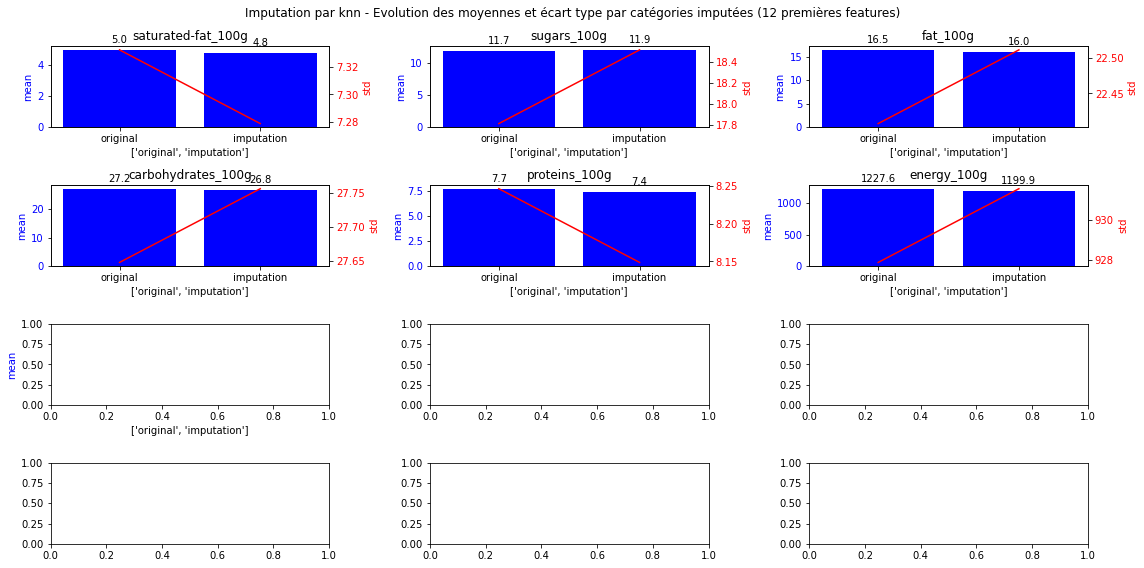

In [163]:
to_be_completed = percent_of_nans[(percent_of_nans < 25) & (percent_of_nans > 0)]
to_be_completed_high_density = to_be_completed.filter(like='_100g')
data=imputation(data,to_be_completed_high_density,'knn')

<b  style="background-color:tomato;font-size:12px;">&nbsp;&nbsp;&nbsp;&nbsp;7.2. Mid Density Features<b>
    <a id="impute_mid_density"></a>  

In [ ]:
to_be_completed = percent_of_nans[(percent_of_nans < 50) & (percent_of_nans >= 25 )]
to_be_completed_average_density = to_be_completed.filter(like='_100g')
data=imputation(data,to_be_completed_average_density,'mean')

In [165]:
data.to_csv('../dataset/cleaned-dataset.csv', sep='\t', encoding='utf-8')